In [ ]:
# %%

os.chdir('/home/oban/Desktop/Volga/stellar-classification')
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns

import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import (Dataset, TensorDataset, DataLoader, 
                              WeightedRandomSampler, random_split)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# %%

hdul = fits.open('data/dataset3_subset2.fits')
dataset = hdul[1].data
hdul.close()

In [ ]:
# %%

# trsvchn's answer on stackoverflow at: https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

class GaussianNoise(torch.nn.Module):
    def __init__(self, mean: float, sigma_r: tuple):
        super().__init__()
        self.mean = mean
        self.sigma_r = sigma_r

    def forward(self, spectra):
        sigma = torch.Tensor((1)).uniform_(*self.sigma_r).cuda()
        noise = self.mean + torch.randn_like(spectra).cuda() * sigma
        out = spectra + noise
        return out

def split_dataset(data, label, dataset, split, **kwargs):
    x = data[split]
    y = label[split]
    return dataset((x,y),**kwargs)

In [ ]:
# %%

flux_numpy = dataset.FLUX.newbyteorder().byteswap()

from eval_utils import label_field, stellar_metrics

label_f = label_field(dataset, regr=False, new=True)
# label_f_old = label_field(dataset_old, regr=False, new=False)

classes = label_f.classes
indices = label_f.ord_to_idx(classes)

splits = list(range(0,len(dataset)))

train, test_val = train_test_split(splits, test_size=0.3, 
                                   random_state=1337, stratify=indices)

ones = np.where(np.unique(classes[test_val],return_counts=True)[1] == 1)

if len(ones) != 0: 
    for i in ones[0]:
        label = label_f.idx_to_ord(i)
        idx = np.where(classes[train] == label)[0][-1]
        real_idx = train.pop(idx)
        test_val.append(real_idx)

val, test = train_test_split(test_val, test_size=0.5, 
                             random_state=1337, stratify=indices[test_val])

assert sum([len(set(classes[i])) for i in [train, val, test]]) % 3 == 0

In [ ]:
# %%

flux = torch.tensor(flux_numpy).cuda().float()
labels = torch.tensor(indices).cuda().int() #indices

gaussian_noise = GaussianNoise(mean=0,sigma_r=(0.01,0.05))

train_iter = split_dataset(flux, labels, CustomTensorDataset, 
                           train, transform=gaussian_noise)

val_iter = split_dataset(flux, labels, CustomTensorDataset, val)

test_iter = split_dataset(flux, labels, CustomTensorDataset, test)

weights = pd.Series(indices[train]).value_counts()

random_sample = WeightedRandomSampler(weights=max(weights)/weights[indices[train]].values,
                                      num_samples=len(indices[train]))

train_loader = DataLoader(train_iter, 8, sampler=random_sample)
val_loader = DataLoader(val_iter, 16)
test_loader = DataLoader(test_iter, 16)

In [ ]:
# %%

def trainer(dataloader, model, loss, optimizer):
    losses = []
    preds = []
    actuals = []
    model.train()
    for fluxes, labels in tqdm.tqdm(dataloader):

        labels = labels.type(torch.LongTensor).cuda()
        fluxes = fluxes.cuda()

        optimizer.zero_grad()
        class_scores = model(fluxes.unsqueeze(1))
        train_loss = loss(class_scores, labels)
        train_loss.backward()
        optimizer.step()
    
        losses.append(train_loss.item())
        preds.extend(class_scores.argmax(dim=1).tolist())
        actuals.extend(labels.tolist())

    inter_sm = stellar_metrics(label_f, preds, actuals, True, False)
    f1 = inter_sm.f1_macro()
    qwk = inter_sm.two_stage_qwk('q')

    return losses, f1, qwk

def validator(dataloader, model, loss, test=False):
    losses = []
    preds = []
    actuals = []
    model.eval()
    with torch.no_grad():
        if not test:
            for fluxes, labels in dataloader:
                labels = labels.type(torch.LongTensor).cuda()
                fluxes = fluxes.cuda()

                class_scores = model(fluxes.unsqueeze(1))
                val_loss = loss(class_scores, labels)
                losses.append(val_loss.item())
                preds.extend(class_scores.argmax(dim=1).tolist())
                actuals.extend(labels.tolist())

            inter_sm = stellar_metrics(label_f, preds, actuals, True, False)
            f1 = inter_sm.f1_macro()
            qwk = inter_sm.two_stage_qwk('q')

            return losses, f1, qwk

        if test:
            for fluxes, labels in dataloader:
                labels = labels.type(torch.LongTensor).cuda()
                fluxes = fluxes.cuda()

                class_scores = model(fluxes)
                class_preds = class_scores.argmax(dim=1)
                preds.extend(class_preds.tolist())
                actuals.extend(labels.tolist())

            return preds, actuals

class2coords = torch.tensor(
    label_f.to_regr(np.unique(classes),idx=False),
    dtype=torch.float32)

class OrdinalLoss(nn.Module):
    def __init__(self, class2coords, alpha, betas=[1,1]):
        super().__init__()
        # register as a buffer so it moves with .to(device), but is not trained
        self.register_buffer('coords', class2coords)  
        self.alpha = torch.tensor(alpha).cuda()
        self.betas = torch.tensor(betas).cuda()

    def forward(self, logits, target):
        probs = logits.softmax(dim=1)
        pred_xy = probs @ self.coords
        true_xy = self.coords[target]

        loss_xent = F.cross_entropy(logits, target)
        loss_ord = F.mse_loss(self.betas*pred_xy, self.betas*true_xy)
        return (1-self.alpha)*loss_xent + self.alpha*loss_ord

In [ ]:
# %%

import torch
import torch.nn as nn

from convtran.model import ConvTran

torch.manual_seed(1337)
torch.cuda.manual_seed(1337)
torch.cuda.manual_seed_all(1337)

model_config = {
    'Data_shape': (0,1,flux_numpy.shape[1]),
    'emb_size': 64,
    'dim_ff': 256,
    'num_heads': 16,
    'Fix_pos_encode': 'tAPE',
    'Rel_pos_encode': None,
    'dropout': 1e-2,
    'num_classes': len(label_f.unique)
}

model = ConvTran(model_config).cuda()

In [ ]:
# %%

custom_loss = OrdinalLoss(class2coords, 0.75, betas=[1,1.5]).cuda()

adamw = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9,0.95))

In [ ]:
# %%

folder_name = 'convtran_test3'
path = f'models/weights/convtran/{folder_name}'
if not os.path.exists(path):
    os.mkdir(path)

epochs = 200

losses = []
metrics = []

best_f1 = 0.4

for i in range(epochs):
    tr_l, tr_f1, tr_qwk = trainer(train_loader, model, custom_loss, adamw)
    vl_l, vl_f1, vl_qwk = validator(test_loader, model, custom_loss)

    losses.extend([tr_l, vl_l])
    metrics.append((
        np.mean(tr_l), tr_f1, tr_qwk,
        np.mean(vl_l), vl_f1, vl_qwk
    ))

    # scheduler.step(vl_f1)

    if vl_f1 > best_f1 * 1.01:
        # early_stop_counter = 0
        best_f1 = vl_f1
        print(f"New best model found at epoch {i}")
        torch.save(model.state_dict(), f'{path}/best_convtran{i}.pth.tar')
        # early_stop_counter += 1

    # if early_stop_counter >= 10:
        # print(f'Early stopping at epoch {i}')
        # break
    if i%1 == 0:
        printout = '\t|\t'.join([str(np.round(x,2)) for x in metrics[-1]])
        print(f'''{i+1}/{epochs} \t|\t: {printout}''')

  0%|          | 0/755 [00:00<?, ?it/s]/home/oban/miniconda3/envs/stellar/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969073/work/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 755/755 [01:04<00:00, 11.78it/s]


1/200 	|	: 3.08	|	0.09	|	[0.75 0.25]	|	2.25	|	0.09	|	[0.93 0.39]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


2/200 	|	: 1.99	|	0.23	|	[0.87 0.49]	|	2.14	|	0.16	|	[0.92 0.49]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


3/200 	|	: 1.58	|	0.32	|	[0.93 0.56]	|	1.64	|	0.2	|	[0.87 0.39]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


4/200 	|	: 1.38	|	0.39	|	[0.96 0.63]	|	1.24	|	0.25	|	[0.83 0.17]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


5/200 	|	: 1.19	|	0.45	|	[0.96 0.68]	|	1.15	|	0.3	|	[0.93 0.37]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


6/200 	|	: 1.11	|	0.48	|	[0.97 0.7 ]	|	0.91	|	0.38	|	[0.89 0.27]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


7/200 	|	: 1.06	|	0.49	|	[0.98 0.7 ]	|	1.03	|	0.38	|	[0.96 0.44]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


8/200 	|	: 0.97	|	0.52	|	[0.98 0.74]	|	1.1	|	0.39	|	[0.88 0.42]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


New best model found at epoch 8
9/200 	|	: 0.92	|	0.54	|	[0.98 0.76]	|	0.99	|	0.44	|	[0.97 0.65]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


10/200 	|	: 0.88	|	0.56	|	[0.98 0.77]	|	0.99	|	0.35	|	[0.96 0.62]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


11/200 	|	: 0.87	|	0.57	|	[0.98 0.78]	|	0.81	|	0.44	|	[0.91 0.4 ]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


12/200 	|	: 0.85	|	0.57	|	[0.98 0.78]	|	1.16	|	0.4	|	[0.96 0.46]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


13/200 	|	: 0.78	|	0.6	|	[0.98 0.78]	|	0.83	|	0.43	|	[0.96 0.6 ]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


New best model found at epoch 13
14/200 	|	: 0.77	|	0.6	|	[0.99 0.8 ]	|	0.78	|	0.47	|	[0.96 0.55]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


15/200 	|	: 0.78	|	0.61	|	[0.99 0.8 ]	|	0.83	|	0.45	|	[0.97 0.66]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


16/200 	|	: 0.71	|	0.63	|	[0.99 0.81]	|	0.86	|	0.47	|	[0.95 0.6 ]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


17/200 	|	: 0.72	|	0.62	|	[0.99 0.81]	|	1.06	|	0.45	|	[0.96 0.58]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


18/200 	|	: 0.69	|	0.63	|	[0.98 0.81]	|	0.77	|	0.46	|	[0.94 0.52]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


19/200 	|	: 0.68	|	0.64	|	[0.99 0.82]	|	0.74	|	0.45	|	[0.95 0.5 ]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


New best model found at epoch 19
20/200 	|	: 0.66	|	0.65	|	[0.99 0.83]	|	0.77	|	0.5	|	[0.95 0.55]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


21/200 	|	: 0.62	|	0.65	|	[0.99 0.83]	|	0.79	|	0.44	|	[0.97 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


22/200 	|	: 0.64	|	0.66	|	[0.99 0.83]	|	0.81	|	0.5	|	[0.97 0.66]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


23/200 	|	: 0.63	|	0.67	|	[0.99 0.83]	|	0.87	|	0.47	|	[0.91 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


24/200 	|	: 0.64	|	0.68	|	[0.99 0.84]	|	0.76	|	0.49	|	[0.96 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


25/200 	|	: 0.62	|	0.67	|	[0.99 0.86]	|	0.81	|	0.49	|	[0.97 0.68]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


26/200 	|	: 0.58	|	0.69	|	[0.99 0.86]	|	0.67	|	0.5	|	[0.98 0.66]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


27/200 	|	: 0.59	|	0.69	|	[0.99 0.87]	|	0.78	|	0.49	|	[0.96 0.62]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


28/200 	|	: 0.56	|	0.7	|	[0.99 0.87]	|	0.86	|	0.49	|	[0.96 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


29/200 	|	: 0.58	|	0.69	|	[0.99 0.86]	|	0.76	|	0.47	|	[0.95 0.53]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


30/200 	|	: 0.57	|	0.7	|	[0.99 0.86]	|	0.86	|	0.46	|	[0.94 0.46]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


31/200 	|	: 0.56	|	0.7	|	[0.99 0.87]	|	0.75	|	0.46	|	[0.96 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


New best model found at epoch 31
32/200 	|	: 0.55	|	0.7	|	[0.99 0.86]	|	0.73	|	0.52	|	[0.95 0.49]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


33/200 	|	: 0.56	|	0.7	|	[0.99 0.87]	|	0.71	|	0.45	|	[0.95 0.57]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


34/200 	|	: 0.55	|	0.7	|	[0.99 0.88]	|	0.72	|	0.5	|	[0.95 0.63]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


35/200 	|	: 0.54	|	0.71	|	[0.99 0.87]	|	0.67	|	0.51	|	[0.94 0.56]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


36/200 	|	: 0.52	|	0.72	|	[0.99 0.88]	|	0.77	|	0.48	|	[0.97 0.63]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


37/200 	|	: 0.56	|	0.72	|	[0.99 0.87]	|	0.82	|	0.51	|	[0.97 0.6 ]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


38/200 	|	: 0.54	|	0.7	|	[0.99 0.88]	|	0.78	|	0.48	|	[0.94 0.52]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


39/200 	|	: 0.51	|	0.71	|	[0.99 0.88]	|	0.69	|	0.49	|	[0.97 0.65]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


40/200 	|	: 0.53	|	0.72	|	[0.99 0.87]	|	0.72	|	0.5	|	[0.97 0.58]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


41/200 	|	: 0.52	|	0.71	|	[0.99 0.88]	|	0.75	|	0.49	|	[0.95 0.57]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


42/200 	|	: 0.49	|	0.73	|	[0.99 0.88]	|	0.7	|	0.52	|	[0.97 0.56]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


43/200 	|	: 0.54	|	0.72	|	[0.99 0.89]	|	0.88	|	0.46	|	[0.94 0.5 ]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


44/200 	|	: 0.5	|	0.72	|	[0.99 0.89]	|	0.82	|	0.49	|	[0.94 0.51]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


New best model found at epoch 44
45/200 	|	: 0.51	|	0.72	|	[0.99 0.87]	|	0.71	|	0.53	|	[0.93 0.6 ]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


46/200 	|	: 0.49	|	0.73	|	[0.99 0.87]	|	0.79	|	0.5	|	[0.96 0.65]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


47/200 	|	: 0.49	|	0.73	|	[0.99 0.88]	|	0.7	|	0.48	|	[0.94 0.56]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


48/200 	|	: 0.47	|	0.73	|	[0.99 0.89]	|	0.77	|	0.47	|	[0.95 0.55]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


49/200 	|	: 0.5	|	0.73	|	[0.99 0.88]	|	0.82	|	0.51	|	[0.96 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


50/200 	|	: 0.48	|	0.74	|	[0.99 0.91]	|	0.73	|	0.51	|	[0.96 0.55]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


51/200 	|	: 0.49	|	0.73	|	[0.99 0.89]	|	0.74	|	0.5	|	[0.97 0.58]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


52/200 	|	: 0.47	|	0.74	|	[0.99 0.9 ]	|	0.73	|	0.5	|	[0.94 0.49]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


53/200 	|	: 0.47	|	0.74	|	[0.99 0.9 ]	|	0.75	|	0.51	|	[0.96 0.52]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


54/200 	|	: 0.47	|	0.74	|	[0.99 0.89]	|	0.87	|	0.49	|	[0.96 0.54]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


55/200 	|	: 0.48	|	0.74	|	[0.99 0.9 ]	|	0.81	|	0.51	|	[0.96 0.5 ]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


56/200 	|	: 0.45	|	0.76	|	[0.99 0.9 ]	|	0.71	|	0.5	|	[0.96 0.6 ]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


57/200 	|	: 0.46	|	0.74	|	[0.99 0.88]	|	0.73	|	0.53	|	[0.95 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


58/200 	|	: 0.46	|	0.74	|	[0.99 0.9 ]	|	0.72	|	0.53	|	[0.97 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


59/200 	|	: 0.47	|	0.74	|	[0.99 0.89]	|	0.79	|	0.48	|	[0.96 0.57]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


New best model found at epoch 59
60/200 	|	: 0.46	|	0.75	|	[0.99 0.91]	|	0.71	|	0.55	|	[0.96 0.58]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


61/200 	|	: 0.46	|	0.75	|	[0.99 0.91]	|	0.71	|	0.48	|	[0.96 0.56]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


62/200 	|	: 0.46	|	0.75	|	[0.99 0.91]	|	0.71	|	0.51	|	[0.96 0.52]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


63/200 	|	: 0.46	|	0.75	|	[0.99 0.9 ]	|	0.7	|	0.5	|	[0.95 0.54]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


64/200 	|	: 0.46	|	0.75	|	[0.99 0.88]	|	0.83	|	0.53	|	[0.96 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


65/200 	|	: 0.44	|	0.76	|	[0.99 0.9 ]	|	0.67	|	0.53	|	[0.96 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


66/200 	|	: 0.46	|	0.75	|	[0.99 0.9 ]	|	0.8	|	0.48	|	[0.96 0.56]


100%|██████████| 755/755 [01:03<00:00, 11.87it/s]


67/200 	|	: 0.46	|	0.76	|	[0.99 0.9 ]	|	0.69	|	0.53	|	[0.96 0.56]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


68/200 	|	: 0.46	|	0.75	|	[0.99 0.9 ]	|	0.7	|	0.52	|	[0.95 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


69/200 	|	: 0.46	|	0.75	|	[1.   0.91]	|	0.69	|	0.49	|	[0.96 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


70/200 	|	: 0.42	|	0.76	|	[0.99 0.91]	|	0.74	|	0.49	|	[0.95 0.56]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


71/200 	|	: 0.46	|	0.75	|	[0.99 0.89]	|	0.68	|	0.51	|	[0.95 0.56]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


72/200 	|	: 0.46	|	0.76	|	[0.99 0.91]	|	0.85	|	0.47	|	[0.97 0.56]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


73/200 	|	: 0.45	|	0.76	|	[0.99 0.91]	|	0.67	|	0.51	|	[0.96 0.57]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


74/200 	|	: 0.43	|	0.76	|	[0.99 0.91]	|	0.7	|	0.54	|	[0.95 0.53]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


75/200 	|	: 0.44	|	0.76	|	[0.99 0.91]	|	0.84	|	0.5	|	[0.94 0.5 ]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


76/200 	|	: 0.42	|	0.76	|	[0.99 0.9 ]	|	0.7	|	0.54	|	[0.96 0.5 ]


100%|██████████| 755/755 [01:03<00:00, 11.88it/s]


77/200 	|	: 0.41	|	0.77	|	[0.99 0.9 ]	|	0.7	|	0.52	|	[0.96 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


78/200 	|	: 0.41	|	0.77	|	[0.99 0.92]	|	0.71	|	0.53	|	[0.96 0.49]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


79/200 	|	: 0.43	|	0.77	|	[0.99 0.9 ]	|	0.74	|	0.54	|	[0.96 0.63]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


80/200 	|	: 0.41	|	0.77	|	[0.99 0.91]	|	0.73	|	0.52	|	[0.97 0.57]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


81/200 	|	: 0.41	|	0.76	|	[0.99 0.92]	|	0.73	|	0.5	|	[0.95 0.53]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


82/200 	|	: 0.42	|	0.77	|	[0.99 0.9 ]	|	0.81	|	0.53	|	[0.94 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


83/200 	|	: 0.42	|	0.78	|	[0.99 0.91]	|	0.71	|	0.54	|	[0.96 0.58]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


84/200 	|	: 0.43	|	0.76	|	[0.99 0.9 ]	|	0.7	|	0.53	|	[0.93 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


85/200 	|	: 0.42	|	0.77	|	[0.99 0.91]	|	0.7	|	0.52	|	[0.95 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


New best model found at epoch 85
86/200 	|	: 0.42	|	0.77	|	[0.99 0.91]	|	0.72	|	0.56	|	[0.96 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


87/200 	|	: 0.41	|	0.78	|	[0.99 0.91]	|	0.71	|	0.55	|	[0.96 0.62]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


88/200 	|	: 0.42	|	0.77	|	[0.99 0.91]	|	0.7	|	0.51	|	[0.96 0.6 ]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


89/200 	|	: 0.4	|	0.78	|	[1.   0.92]	|	0.74	|	0.5	|	[0.97 0.67]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


90/200 	|	: 0.42	|	0.78	|	[0.99 0.9 ]	|	0.67	|	0.56	|	[0.97 0.63]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


91/200 	|	: 0.42	|	0.77	|	[1.   0.92]	|	0.72	|	0.52	|	[0.96 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


92/200 	|	: 0.39	|	0.78	|	[1.   0.92]	|	0.71	|	0.53	|	[0.96 0.56]


100%|██████████| 755/755 [01:03<00:00, 11.91it/s]


New best model found at epoch 92
93/200 	|	: 0.42	|	0.77	|	[1.   0.91]	|	0.69	|	0.57	|	[0.97 0.65]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


94/200 	|	: 0.41	|	0.78	|	[1.   0.92]	|	0.65	|	0.56	|	[0.96 0.58]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


95/200 	|	: 0.41	|	0.77	|	[1.   0.93]	|	0.65	|	0.56	|	[0.97 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


96/200 	|	: 0.39	|	0.78	|	[1.   0.92]	|	0.7	|	0.5	|	[0.96 0.51]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


97/200 	|	: 0.39	|	0.78	|	[1.   0.93]	|	0.7	|	0.5	|	[0.96 0.63]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


98/200 	|	: 0.38	|	0.78	|	[1.   0.92]	|	0.7	|	0.52	|	[0.96 0.67]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


99/200 	|	: 0.4	|	0.78	|	[0.99 0.91]	|	0.68	|	0.53	|	[0.95 0.55]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


100/200 	|	: 0.4	|	0.78	|	[1.   0.93]	|	0.65	|	0.55	|	[0.97 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


101/200 	|	: 0.38	|	0.79	|	[1.   0.93]	|	0.69	|	0.54	|	[0.96 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


102/200 	|	: 0.41	|	0.78	|	[1.   0.93]	|	0.63	|	0.54	|	[0.96 0.55]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


103/200 	|	: 0.38	|	0.78	|	[0.99 0.91]	|	0.75	|	0.51	|	[0.96 0.57]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


104/200 	|	: 0.41	|	0.77	|	[0.99 0.92]	|	0.74	|	0.5	|	[0.96 0.57]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


105/200 	|	: 0.39	|	0.78	|	[0.99 0.92]	|	0.65	|	0.51	|	[0.97 0.62]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


106/200 	|	: 0.38	|	0.78	|	[1.   0.92]	|	0.63	|	0.52	|	[0.96 0.55]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


107/200 	|	: 0.36	|	0.79	|	[0.99 0.92]	|	0.72	|	0.53	|	[0.96 0.62]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


108/200 	|	: 0.4	|	0.78	|	[1.   0.92]	|	0.69	|	0.55	|	[0.97 0.53]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


109/200 	|	: 0.4	|	0.78	|	[0.99 0.92]	|	0.64	|	0.54	|	[0.96 0.57]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


110/200 	|	: 0.4	|	0.78	|	[1.   0.92]	|	0.7	|	0.53	|	[0.96 0.6 ]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


111/200 	|	: 0.38	|	0.79	|	[1.   0.93]	|	0.71	|	0.56	|	[0.98 0.64]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


112/200 	|	: 0.4	|	0.78	|	[0.99 0.94]	|	0.66	|	0.56	|	[0.96 0.57]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


113/200 	|	: 0.38	|	0.78	|	[0.99 0.93]	|	0.7	|	0.51	|	[0.96 0.53]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


114/200 	|	: 0.38	|	0.79	|	[1.   0.92]	|	0.67	|	0.51	|	[0.9  0.52]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


115/200 	|	: 0.37	|	0.79	|	[1.   0.93]	|	0.7	|	0.53	|	[0.94 0.55]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


116/200 	|	: 0.38	|	0.79	|	[0.99 0.92]	|	0.76	|	0.51	|	[0.95 0.56]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


117/200 	|	: 0.36	|	0.8	|	[1.   0.93]	|	0.66	|	0.53	|	[0.96 0.58]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


118/200 	|	: 0.39	|	0.78	|	[1.   0.93]	|	0.66	|	0.51	|	[0.97 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


119/200 	|	: 0.38	|	0.78	|	[0.99 0.92]	|	0.74	|	0.52	|	[0.96 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


120/200 	|	: 0.37	|	0.79	|	[1.   0.93]	|	0.64	|	0.52	|	[0.97 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


121/200 	|	: 0.4	|	0.78	|	[1.   0.92]	|	0.76	|	0.52	|	[0.96 0.54]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


122/200 	|	: 0.38	|	0.78	|	[0.99 0.93]	|	0.7	|	0.52	|	[0.94 0.53]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


123/200 	|	: 0.35	|	0.79	|	[1.   0.94]	|	0.67	|	0.53	|	[0.96 0.63]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


124/200 	|	: 0.4	|	0.79	|	[1.   0.92]	|	0.65	|	0.55	|	[0.95 0.53]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


125/200 	|	: 0.38	|	0.79	|	[1.   0.92]	|	0.7	|	0.54	|	[0.96 0.57]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


126/200 	|	: 0.37	|	0.8	|	[1.   0.92]	|	0.66	|	0.53	|	[0.96 0.58]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


127/200 	|	: 0.38	|	0.79	|	[1.   0.93]	|	0.63	|	0.53	|	[0.96 0.57]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


128/200 	|	: 0.36	|	0.79	|	[1.   0.93]	|	0.69	|	0.53	|	[0.95 0.47]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


129/200 	|	: 0.37	|	0.79	|	[0.99 0.92]	|	0.66	|	0.54	|	[0.96 0.63]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


130/200 	|	: 0.37	|	0.79	|	[1.   0.92]	|	0.86	|	0.46	|	[0.94 0.47]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


131/200 	|	: 0.38	|	0.79	|	[1.   0.93]	|	0.77	|	0.53	|	[0.94 0.66]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


132/200 	|	: 0.38	|	0.79	|	[1.   0.93]	|	0.68	|	0.55	|	[0.96 0.55]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


133/200 	|	: 0.37	|	0.79	|	[1.   0.93]	|	0.74	|	0.52	|	[0.96 0.58]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


134/200 	|	: 0.38	|	0.78	|	[1.   0.92]	|	0.68	|	0.52	|	[0.95 0.51]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


135/200 	|	: 0.36	|	0.79	|	[1.   0.94]	|	0.62	|	0.55	|	[0.96 0.63]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


136/200 	|	: 0.37	|	0.79	|	[1.   0.93]	|	0.66	|	0.54	|	[0.96 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


137/200 	|	: 0.36	|	0.79	|	[1.   0.92]	|	0.71	|	0.52	|	[0.97 0.63]


100%|██████████| 755/755 [01:03<00:00, 11.92it/s]


138/200 	|	: 0.37	|	0.8	|	[1.   0.93]	|	0.62	|	0.5	|	[0.97 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.91it/s]


139/200 	|	: 0.37	|	0.8	|	[1.   0.93]	|	0.61	|	0.56	|	[0.96 0.6 ]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


140/200 	|	: 0.36	|	0.8	|	[1.   0.94]	|	0.67	|	0.54	|	[0.97 0.62]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


141/200 	|	: 0.35	|	0.8	|	[1.   0.93]	|	0.65	|	0.48	|	[0.97 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


142/200 	|	: 0.38	|	0.79	|	[1.   0.92]	|	0.6	|	0.56	|	[0.97 0.58]


100%|██████████| 755/755 [01:03<00:00, 11.91it/s]


143/200 	|	: 0.38	|	0.79	|	[1.   0.93]	|	0.66	|	0.54	|	[0.97 0.58]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


144/200 	|	: 0.34	|	0.8	|	[1.   0.94]	|	0.82	|	0.54	|	[0.92 0.49]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


145/200 	|	: 0.35	|	0.8	|	[1.   0.94]	|	0.67	|	0.55	|	[0.95 0.53]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


146/200 	|	: 0.36	|	0.8	|	[1.   0.93]	|	0.69	|	0.54	|	[0.8  0.49]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


147/200 	|	: 0.36	|	0.8	|	[1.   0.93]	|	0.67	|	0.56	|	[0.97 0.56]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


148/200 	|	: 0.36	|	0.8	|	[0.99 0.94]	|	0.63	|	0.53	|	[0.97 0.66]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


149/200 	|	: 0.37	|	0.8	|	[1.   0.93]	|	0.71	|	0.52	|	[0.94 0.57]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


150/200 	|	: 0.37	|	0.8	|	[1.   0.93]	|	0.67	|	0.55	|	[0.97 0.63]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


151/200 	|	: 0.36	|	0.8	|	[1.   0.93]	|	0.68	|	0.54	|	[0.78 0.49]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


152/200 	|	: 0.37	|	0.8	|	[1.   0.92]	|	0.6	|	0.55	|	[0.97 0.6 ]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


153/200 	|	: 0.36	|	0.8	|	[1.   0.94]	|	0.65	|	0.51	|	[0.95 0.6 ]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


154/200 	|	: 0.35	|	0.81	|	[1.   0.93]	|	0.69	|	0.51	|	[0.95 0.54]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


155/200 	|	: 0.35	|	0.8	|	[0.99 0.93]	|	0.71	|	0.51	|	[0.95 0.64]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


156/200 	|	: 0.35	|	0.8	|	[1.   0.94]	|	0.69	|	0.57	|	[0.97 0.68]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


157/200 	|	: 0.35	|	0.8	|	[1.   0.94]	|	0.66	|	0.54	|	[0.97 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


158/200 	|	: 0.36	|	0.8	|	[1.   0.94]	|	0.63	|	0.55	|	[0.97 0.62]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


159/200 	|	: 0.35	|	0.8	|	[1.   0.93]	|	0.66	|	0.53	|	[0.89 0.54]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


160/200 	|	: 0.34	|	0.81	|	[1.   0.94]	|	0.71	|	0.51	|	[0.95 0.45]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


161/200 	|	: 0.37	|	0.8	|	[0.99 0.93]	|	0.69	|	0.5	|	[0.96 0.55]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


162/200 	|	: 0.36	|	0.8	|	[1.   0.93]	|	0.63	|	0.55	|	[0.97 0.62]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


163/200 	|	: 0.34	|	0.81	|	[1.   0.94]	|	0.67	|	0.5	|	[0.96 0.56]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


164/200 	|	: 0.37	|	0.8	|	[0.99 0.94]	|	0.71	|	0.53	|	[0.95 0.56]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


165/200 	|	: 0.34	|	0.81	|	[1.   0.93]	|	0.63	|	0.53	|	[0.96 0.64]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


166/200 	|	: 0.34	|	0.81	|	[1.   0.93]	|	0.72	|	0.51	|	[0.95 0.62]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


167/200 	|	: 0.35	|	0.8	|	[1.   0.93]	|	0.71	|	0.52	|	[0.94 0.58]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


168/200 	|	: 0.35	|	0.81	|	[1.   0.94]	|	0.68	|	0.54	|	[0.95 0.63]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


169/200 	|	: 0.35	|	0.8	|	[1.   0.94]	|	0.78	|	0.53	|	[0.96 0.51]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


170/200 	|	: 0.35	|	0.81	|	[1.   0.93]	|	0.7	|	0.52	|	[0.97 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


171/200 	|	: 0.35	|	0.8	|	[1.   0.93]	|	0.69	|	0.54	|	[0.97 0.55]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


172/200 	|	: 0.36	|	0.8	|	[1.   0.93]	|	0.69	|	0.52	|	[0.95 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


173/200 	|	: 0.35	|	0.81	|	[1.   0.95]	|	0.63	|	0.55	|	[0.95 0.64]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


174/200 	|	: 0.37	|	0.8	|	[1.   0.93]	|	0.66	|	0.5	|	[0.95 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


175/200 	|	: 0.34	|	0.81	|	[1.   0.93]	|	0.71	|	0.49	|	[0.96 0.6 ]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


176/200 	|	: 0.34	|	0.81	|	[1.   0.94]	|	0.68	|	0.52	|	[0.95 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


177/200 	|	: 0.36	|	0.8	|	[1.   0.93]	|	0.67	|	0.51	|	[0.95 0.54]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


178/200 	|	: 0.36	|	0.8	|	[1.   0.94]	|	0.71	|	0.53	|	[0.96 0.55]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


179/200 	|	: 0.33	|	0.81	|	[1.   0.94]	|	0.65	|	0.55	|	[0.96 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


180/200 	|	: 0.34	|	0.8	|	[1.   0.94]	|	0.65	|	0.54	|	[0.95 0.6 ]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


181/200 	|	: 0.33	|	0.81	|	[1.   0.94]	|	0.65	|	0.54	|	[0.89 0.52]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


182/200 	|	: 0.35	|	0.8	|	[1.   0.93]	|	0.67	|	0.53	|	[0.97 0.64]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


183/200 	|	: 0.33	|	0.81	|	[1.   0.92]	|	0.68	|	0.51	|	[0.95 0.55]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


184/200 	|	: 0.37	|	0.8	|	[1.   0.93]	|	0.65	|	0.55	|	[0.75 0.65]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


185/200 	|	: 0.34	|	0.8	|	[0.99 0.94]	|	0.67	|	0.51	|	[0.89 0.47]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


186/200 	|	: 0.36	|	0.8	|	[1.   0.93]	|	0.74	|	0.51	|	[0.95 0.57]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


187/200 	|	: 0.33	|	0.8	|	[1.   0.93]	|	0.66	|	0.51	|	[0.96 0.63]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


188/200 	|	: 0.35	|	0.81	|	[1.   0.94]	|	0.64	|	0.53	|	[0.97 0.62]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


189/200 	|	: 0.33	|	0.8	|	[1.   0.93]	|	0.72	|	0.51	|	[0.95 0.58]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


190/200 	|	: 0.33	|	0.81	|	[1.   0.94]	|	0.68	|	0.5	|	[0.96 0.61]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


191/200 	|	: 0.32	|	0.81	|	[1.   0.93]	|	0.68	|	0.53	|	[0.95 0.58]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


192/200 	|	: 0.34	|	0.81	|	[1.   0.95]	|	0.61	|	0.52	|	[0.94 0.57]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


193/200 	|	: 0.34	|	0.8	|	[1.   0.94]	|	0.64	|	0.53	|	[0.97 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.89it/s]


194/200 	|	: 0.34	|	0.81	|	[1.   0.92]	|	0.66	|	0.5	|	[0.93 0.46]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


195/200 	|	: 0.34	|	0.81	|	[0.99 0.93]	|	0.72	|	0.5	|	[0.95 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


196/200 	|	: 0.35	|	0.8	|	[1.   0.94]	|	0.71	|	0.5	|	[0.96 0.63]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


197/200 	|	: 0.35	|	0.81	|	[1.   0.93]	|	0.74	|	0.5	|	[0.96 0.58]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


198/200 	|	: 0.35	|	0.81	|	[1.   0.93]	|	0.7	|	0.55	|	[0.96 0.52]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


199/200 	|	: 0.35	|	0.81	|	[1.   0.93]	|	0.67	|	0.53	|	[0.96 0.59]


100%|██████████| 755/755 [01:03<00:00, 11.90it/s]


200/200 	|	: 0.33	|	0.81	|	[1.   0.93]	|	0.65	|	0.49	|	[0.97 0.58]


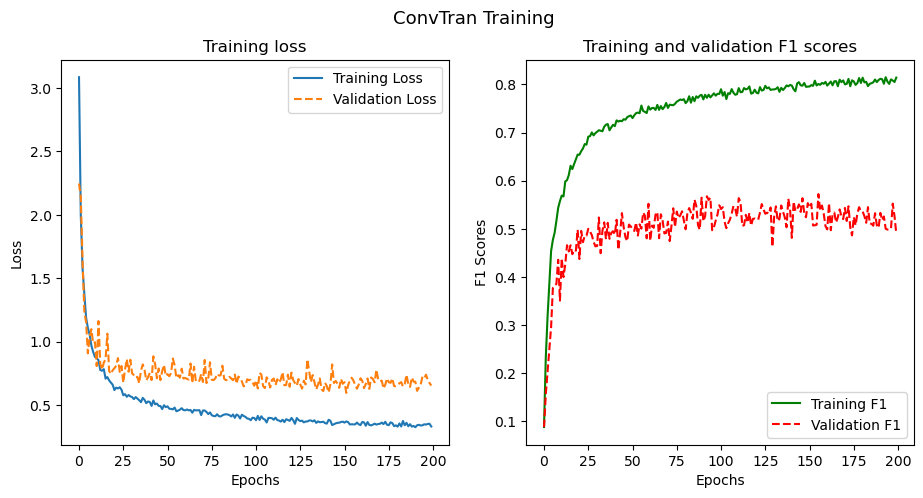

In [ ]:
# %%

fig, (l_ax, f_ax) = plt.subplots(1,2, figsize=(11,5))
fig.suptitle('ConvTran Training',fontsize=13)

l_ax.plot([x[0] for x in metrics])
l_ax.plot([x[3] for x in metrics], linestyle='--')
l_ax.legend(['Training Loss','Validation Loss'])
l_ax.set_xlabel('Epochs')
l_ax.set_ylabel('Loss')
l_ax.set_title('Training loss');

f_ax.plot([x[1] for x in metrics], c='green')
f_ax.plot([x[4] for x in metrics],c='red',linestyle='--')
f_ax.legend(['Training F1','Validation F1'])
f_ax.set_xlabel('Epochs')
f_ax.set_ylabel('F1 Scores')
f_ax.set_title('Training and validation F1 scores');

Text(0.5, 1.0, 'Quadratic Weighted Kappa Scores')

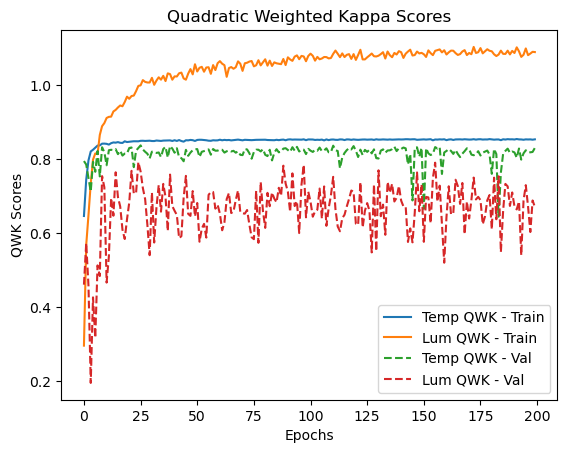

In [ ]:
# %%

temp = np.mean(np.unique(
    label_f.to_regr(label_f.unique,idx=False)[:,0],
    return_counts=True)[1])

lum = np.mean(np.unique(
    label_f.to_regr(label_f.unique,idx=False)[:,1],
    return_counts=True)[1])

t_qwk_t, l_qwk_t = zip(*[x[2] for x in metrics])
t_qwk_v, l_qwk_v = zip(*[x[5] for x in metrics])

plt.plot(np.array(t_qwk_t)*temp/lum)
plt.plot(np.array(l_qwk_t)*lum/temp)
plt.plot(np.array(t_qwk_v)*temp/lum, linestyle='--')
plt.plot(np.array(l_qwk_v)*lum/temp, linestyle='--')
plt.legend([
    'Temp QWK - Train',
    'Lum QWK - Train',
    'Temp QWK - Val',
    'Lum QWK - Val'])
plt.xlabel('Epochs')
plt.ylabel('QWK Scores')
plt.title('Quadratic Weighted Kappa Scores')

In [ ]:
temp

5.571428571428571

In [ ]:
lum

6.5

In [ ]:
# %%

folder_name = 'convtran_test3'
path = f'models/weights/convtran/{folder_name}'
best_i = 92

classifier3 = ConvTran(model_config).to('cuda')
classifier3.load_state_dict(torch.load(f'{path}/best_convtran{best_i}.pth.tar'))

<All keys matched successfully>

In [ ]:
def validator(dataloader, model, loss, test=False):
    losses = []
    preds = []
    actuals = []
    model.eval()
    with torch.no_grad():
        if not test:
            for fluxes, labels in dataloader:
                labels = labels.type(torch.LongTensor).cuda()
                fluxes = fluxes.cuda()

                class_scores = model(fluxes.unsqueeze(1))
                val_loss = loss(class_scores, labels)
                losses.append(val_loss.item())
                preds.extend(class_scores.argmax(dim=1).tolist())
                actuals.extend(labels.tolist())

            inter_sm = stellar_metrics(label_f, preds, actuals, True, False)
            f1 = inter_sm.f1_macro()
            qwk = inter_sm.two_stage_qwk('q')

            return losses, f1, qwk

        if test:
            for fluxes, labels in dataloader:
                labels = labels.type(torch.LongTensor).cuda()
                fluxes = fluxes.cuda()

                class_scores = model(fluxes.unsqueeze(1))
                class_preds = class_scores.argmax(dim=1)
                preds.extend(class_preds.tolist())
                actuals.extend(labels.tolist())

            return preds, actuals

F1 Macro: 56.77%
Mean Absolute Error: 0.23
Q-Weighted Kappa: 97.13%, 65.30%


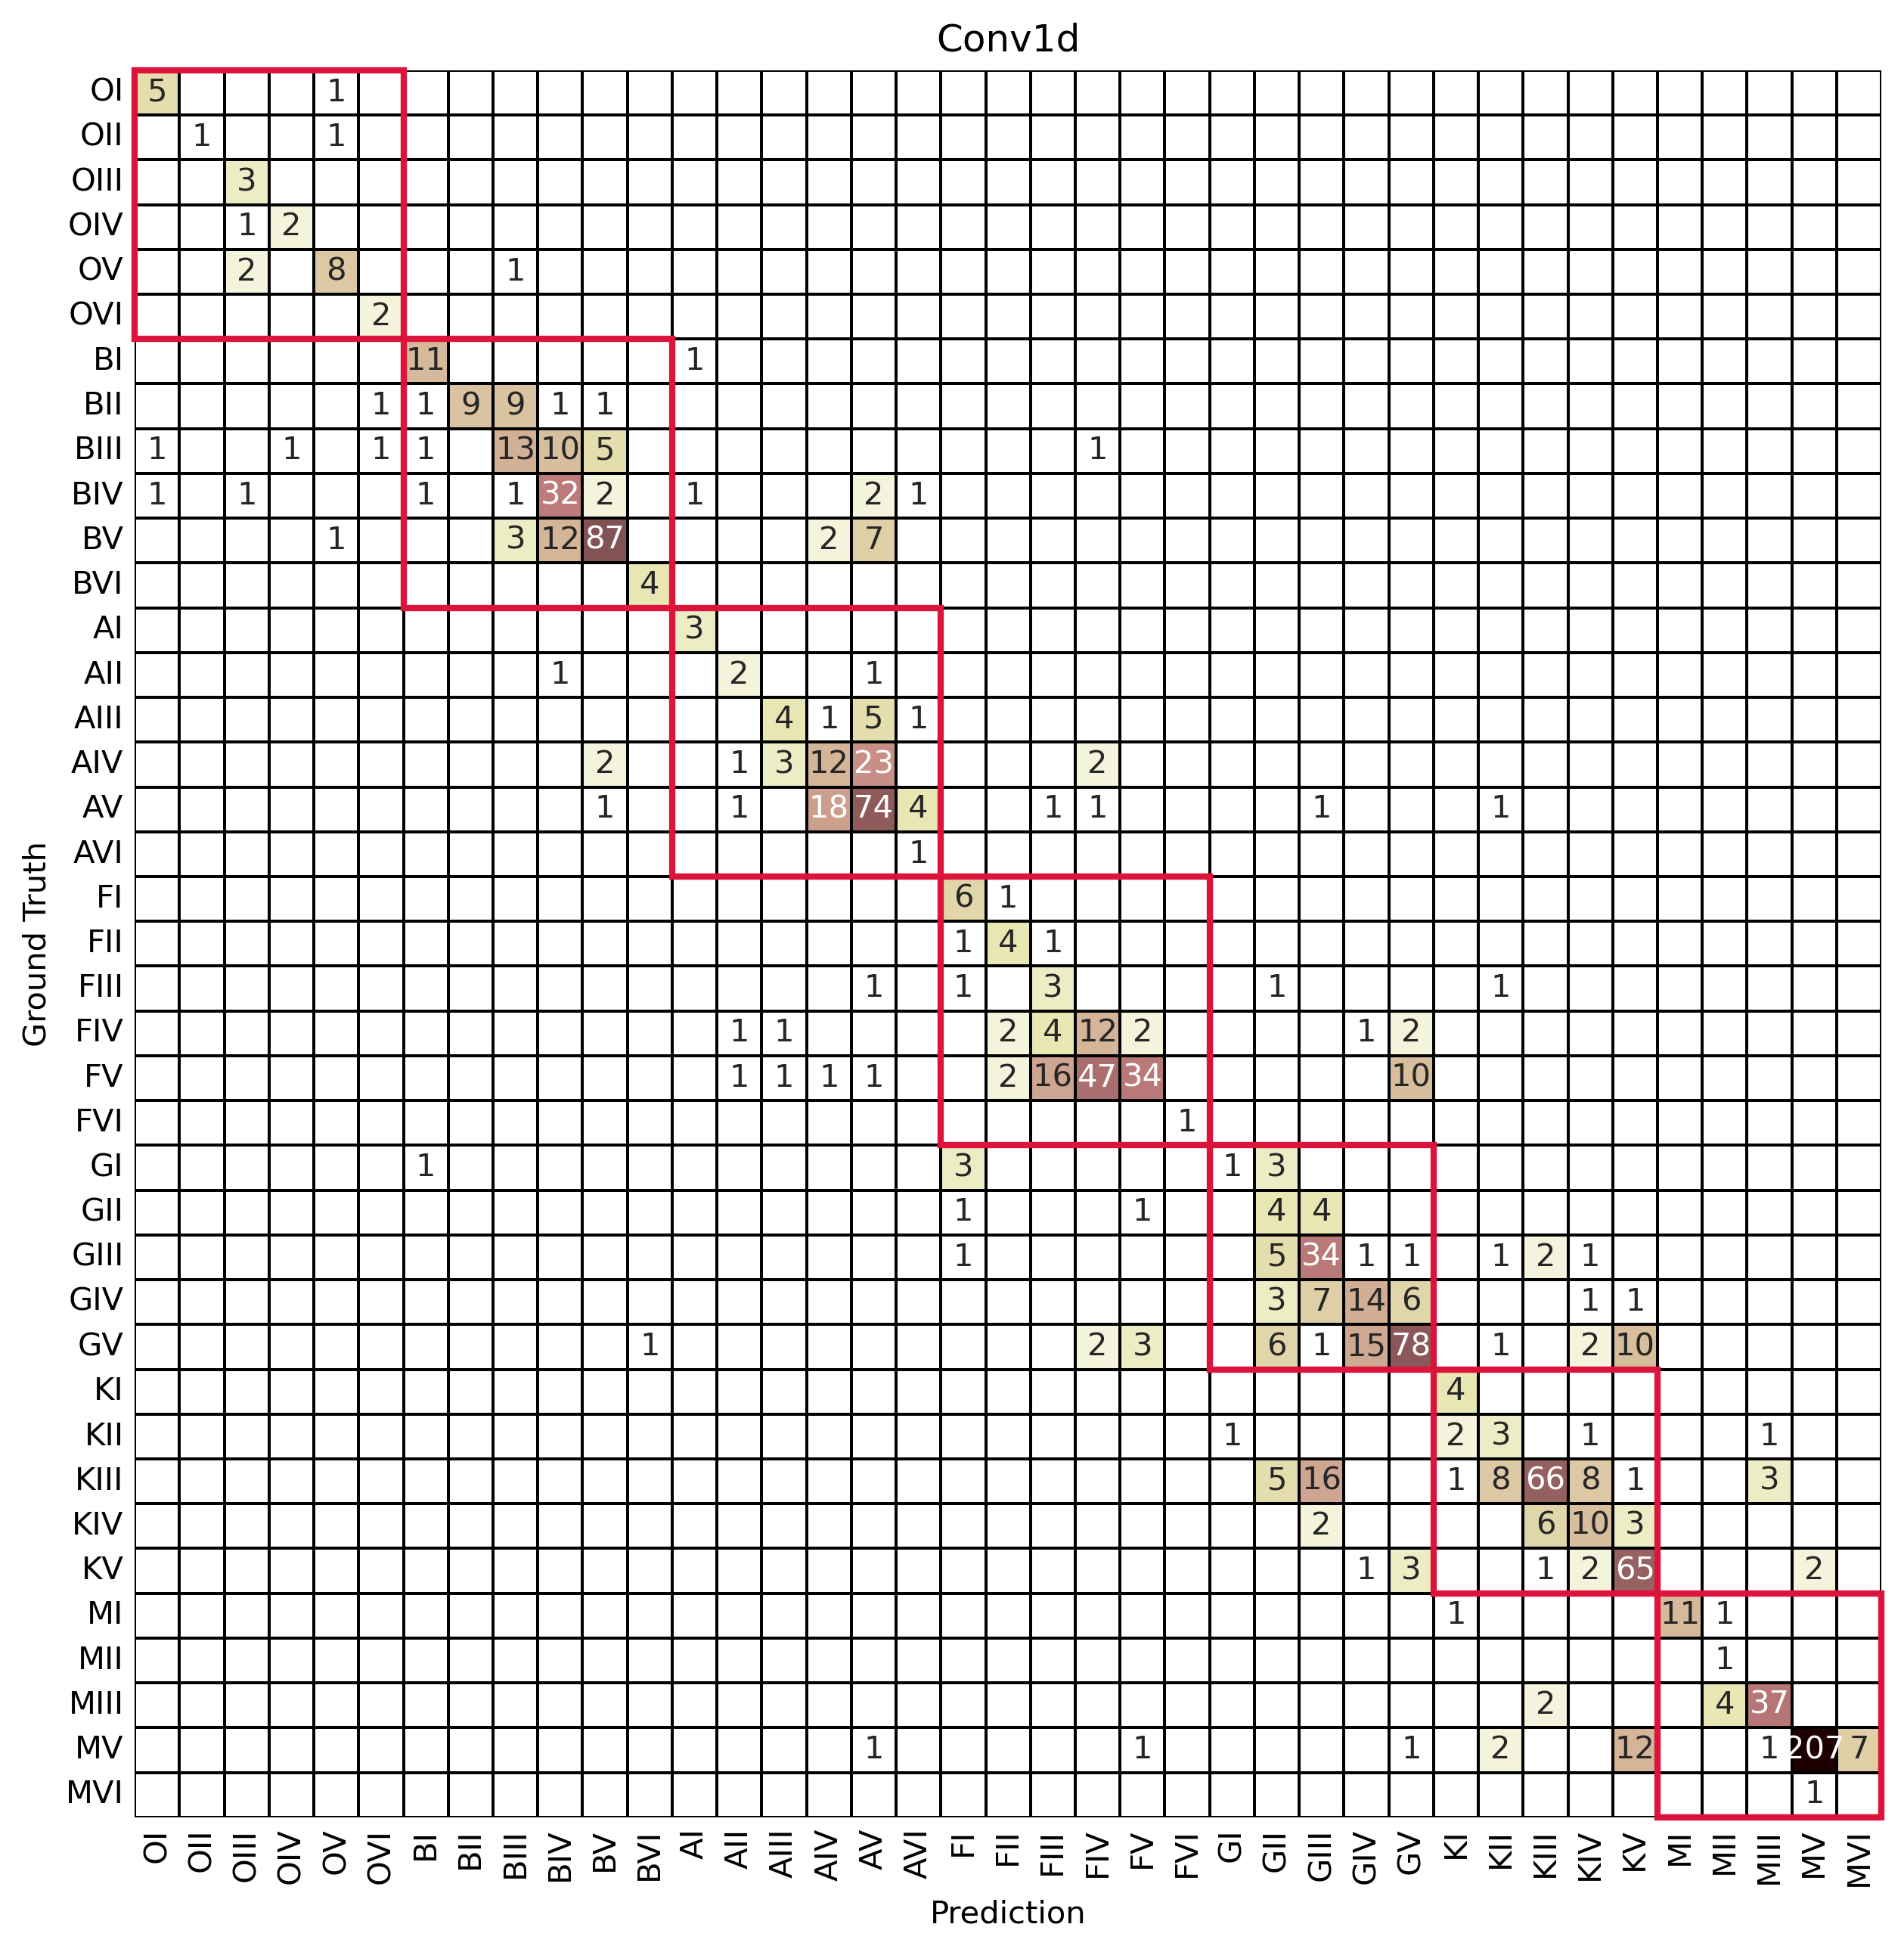

In [ ]:
# %%

preds, actuals = validator(test_loader, classifier3, custom_loss, test=True)
sm = stellar_metrics(label_f, preds, actuals, True, False)

sm.draw_cm('Conv1d', 300, False)

print(f'F1 Macro: {sm.f1_macro():.2%}')
print(f'Mean Absolute Error: {sm.mae():.2f}')
print(f'Q-Weighted Kappa: {sm.two_stage_qwk("q")[0]:.2%}, {sm.two_stage_qwk("q")[1]:.2%}')

In [ ]:
# %%

sm.report('', False)
sm.report('temp', False)
sm.report('lum', False)

              precision    recall  f1-score   support

          OI     0.7143    0.8333    0.7692         6
         OII     1.0000    0.5000    0.6667         2
        OIII     0.4286    1.0000    0.6000         3
         OIV     0.6667    0.6667    0.6667         3
          OV     0.7273    0.7273    0.7273        11
         OVI     0.5000    1.0000    0.6667         2
          BI     0.7333    0.9167    0.8148        12
         BII     1.0000    0.4091    0.5806        22
        BIII     0.4815    0.3939    0.4333        33
         BIV     0.5714    0.7619    0.6531        42
          BV     0.8878    0.7768    0.8286       112
         BVI     0.8000    1.0000    0.8889         4
          AI     0.6000    1.0000    0.7500         3
         AII     0.3333    0.5000    0.4000         4
        AIII     0.4444    0.3636    0.4000        11
         AIV     0.3529    0.2791    0.3117        43
          AV     0.6435    0.7255    0.6820       102
         AVI     0.1429    

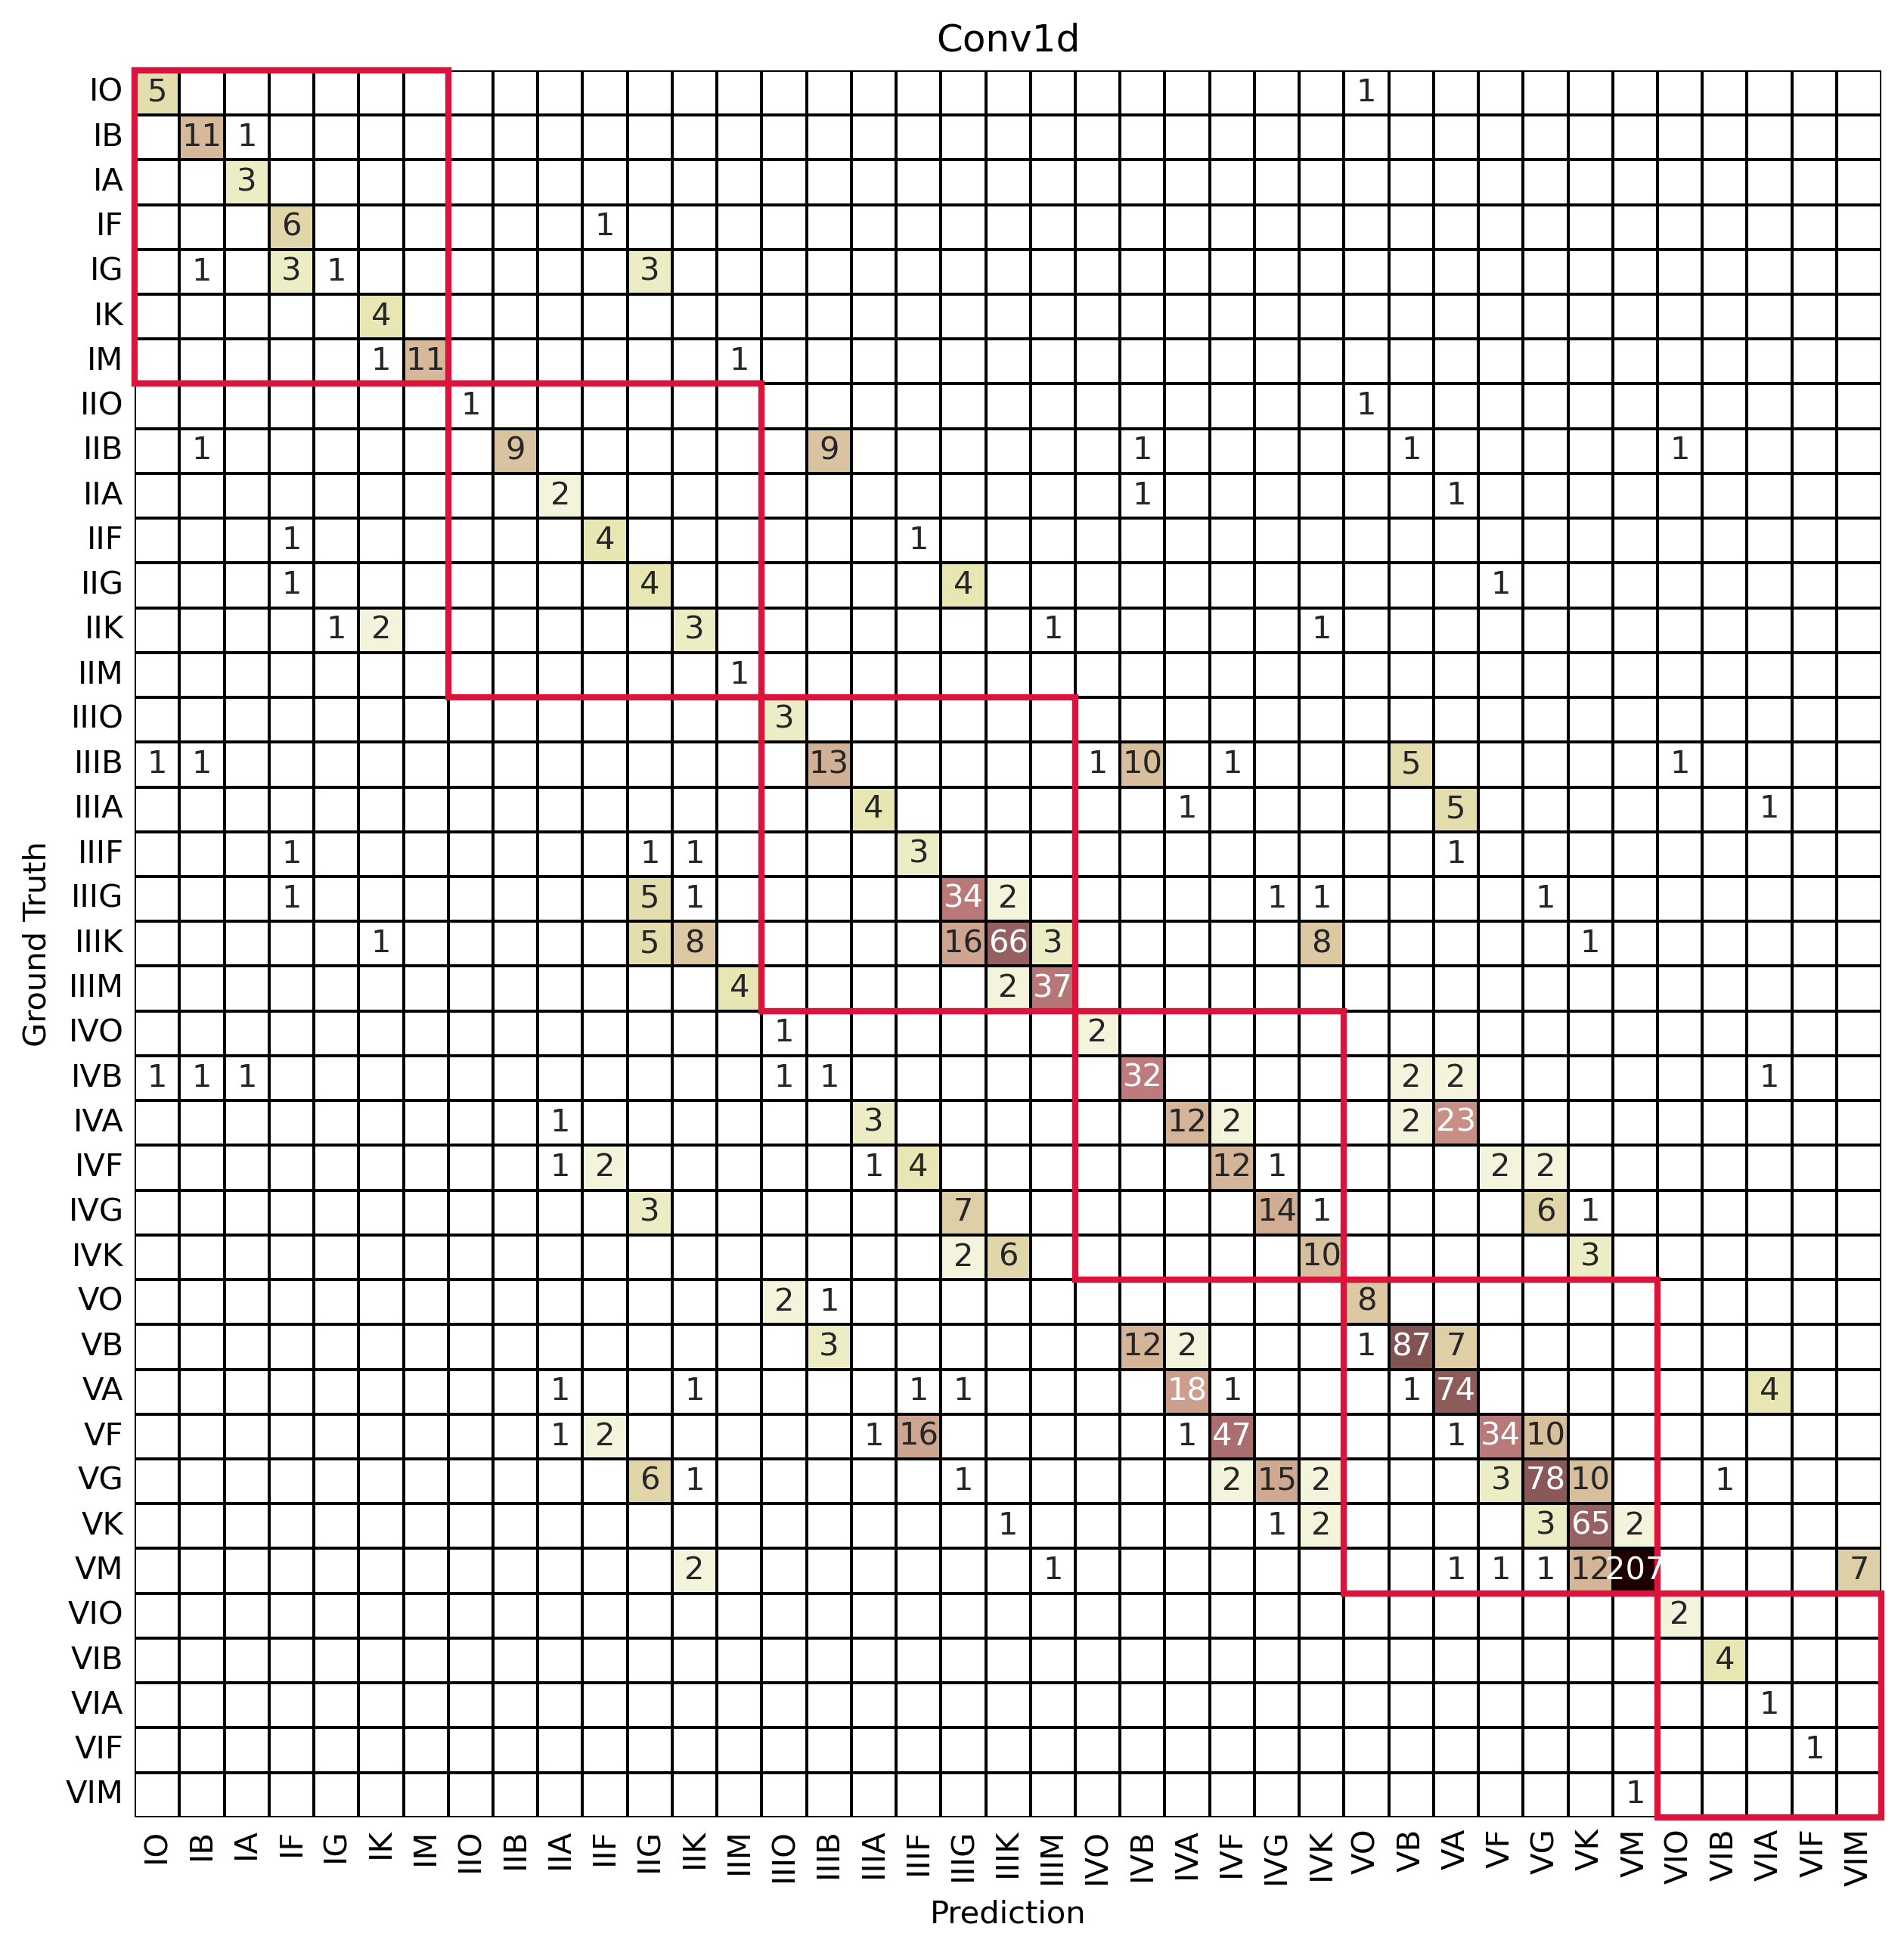

In [ ]:
# %%

sm.draw_cm('Conv1d', 300, True)

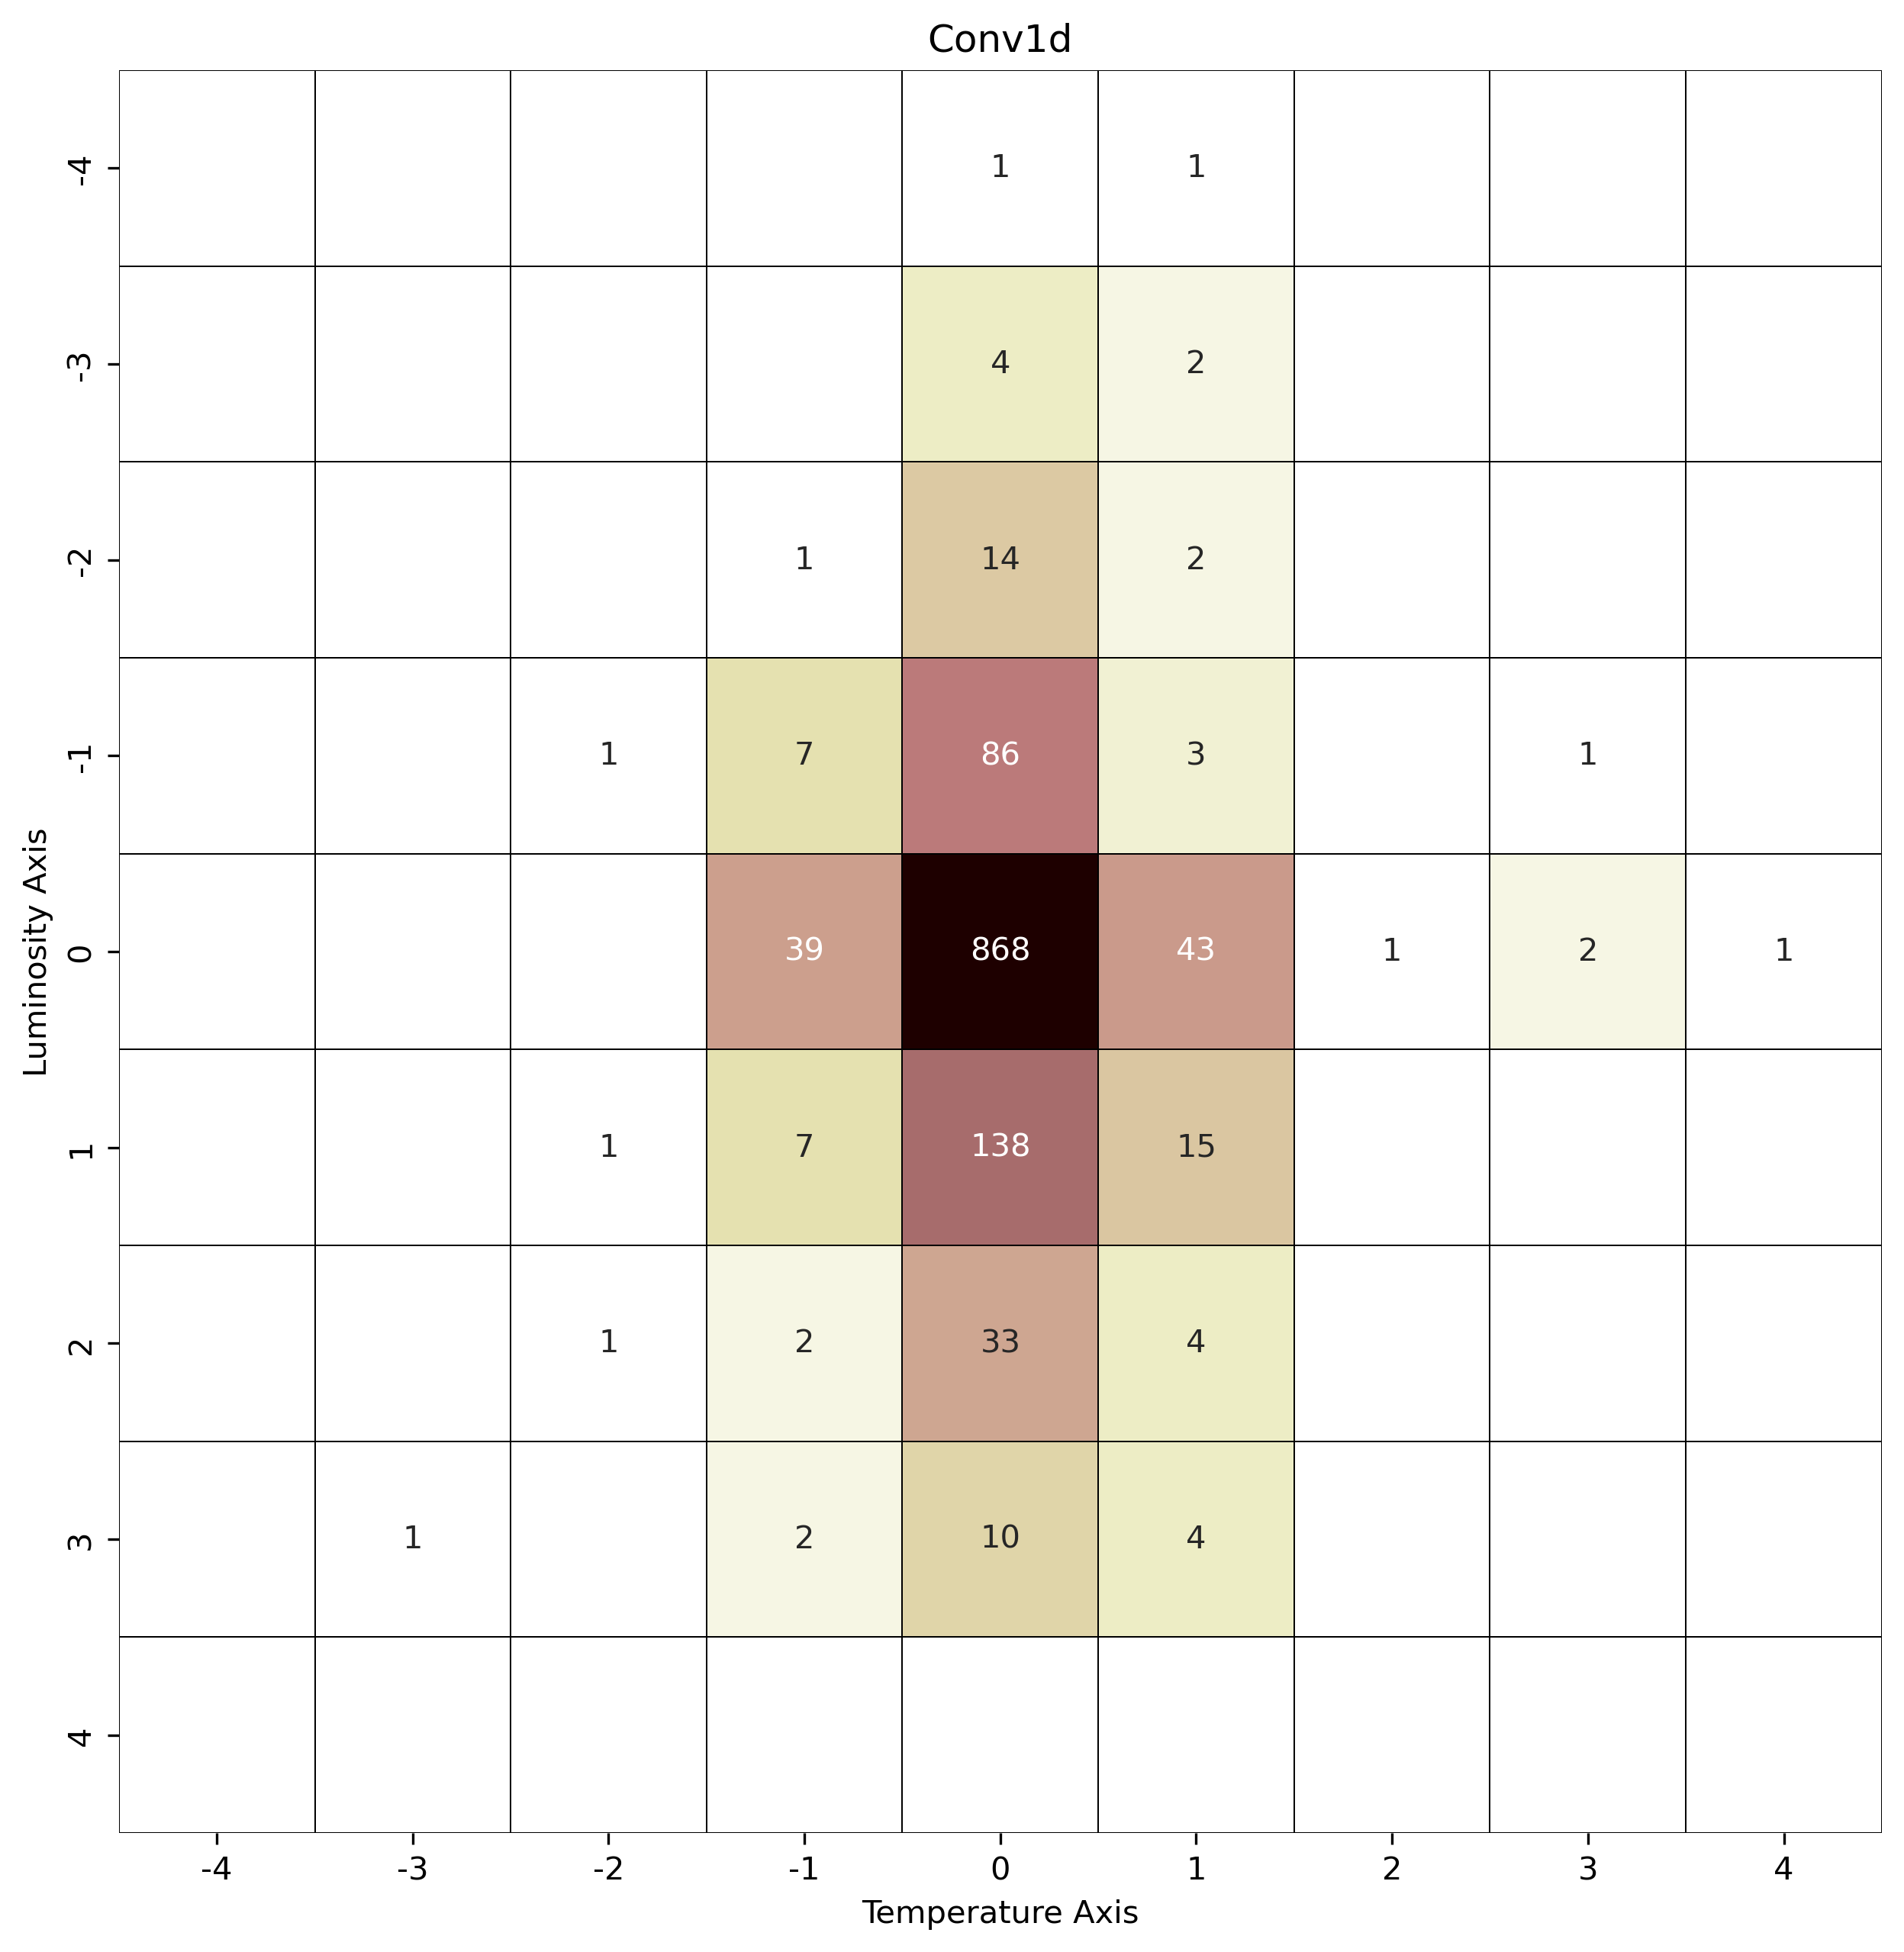

In [ ]:
# %%

sm.draw_ord_cm('Conv1d', 300)